In [1]:
%%bash
# Small dataset
wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
unzip ml-latest-small.zip

# wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
# unzip ml-latest.zip
# mv ml-latest ml-latest-large

--2022-09-27 15:35:22--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

     0K .......... .......... .......... .......... ..........  5%  234K 4s
    50K .......... .......... .......... .......... .......... 10%  472K 3s
   100K .......... .......... .......... .......... .......... 15% 18,2M 2s
   150K .......... .......... .......... .......... .......... 20%  481K 2s
   200K .......... .......... .......... .......... .......... 26% 12,6M 1s
   250K .......... .......... .......... .......... .......... 31% 79,1M 1s
   300K .......... .......... .......... .......... .......... 36%  337M 1s
   350K .......... .......... .......... .......... .......... 41% 24,3M 1s
   400K .......... 

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [2]:
# Imports
import csv
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import sys
from typing import Tuple, List, Iterable, Optional



# Types
TDataSet = Tuple[torch.IntTensor, torch.FloatTensor]

# Constants
TEST_SPLIT = 0.2
DATASET = 'small' # small, large

random.seed(42) # To ensure the same data splitbetween experiments
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device", device)

Using device cpu


In [27]:
# Re-mapper: maps a set of value to 0...k
class Mapper:
  def __init__(self):
    self.values = set()
    self.sorted = None
    self.sorted_inv = None
  
  def add(self, v):
    assert self.sorted is None, "Can't add after build"
    self.values.add(v)
  
  def build(self):
    self.sorted = list(sorted(self.values))
    self.sorted_inv = {v : i for i,v in enumerate(self.sorted)}
  
  def map(self, v):
    assert self.sorted is not None, "Can't map before build"
    assert v in self.values, f"Unknown value {v}"
    return self.sorted_inv[v]
  
  def unmap(self, i):
    assert self.sorted is not None, "Can't unmap before build"
    return self.sorted[i]

def load_data() -> Tuple[TDataSet, TDataSet, int, int]:
  # Loading data
  with open(f'ml-latest-{DATASET}/ratings.csv') as data_file:
    csv_reader = csv.reader(data_file)
    next(csv_reader)
    ratings = [(int(user_id), int(movie_id), float(mark))
      for user_id, movie_id, mark, _ in csv_reader]

  # Chaging the ids
  user_mapper, movie_mapper = Mapper(), Mapper()
  for user_id, movie_id, _ in ratings:
    user_mapper.add(user_id)
    movie_mapper.add(movie_id)

  user_mapper.build()
  movie_mapper.build()
  ratings = [[user_mapper.map(user_id), movie_mapper.map(movie_id), mark]
    for user_id, movie_id, mark in ratings]

  # Displaying info on the data

  nb_users = max([rtg[0] for rtg in ratings])+1
  nb_movies = max([rtg[1] for rtg in ratings])+1
  print(f"{nb_users} users and {nb_movies} movies, with {len(ratings)} ratings (average of {len(ratings)/nb_movies:.2f} ratings by movie, and {len(ratings)/nb_users:.2f} by user)")

  # Spliting data
  n_train = int((1-TEST_SPLIT) * len(ratings))
  random.shuffle(ratings)
  X = [(user_id, movie_id) for user_id, movie_id, _ in ratings]
  Y = [mark for _, _, mark in ratings]

  print(f"{n_train} ratings for training, {len(ratings)-n_train} for testing")
  return ((
      torch.tensor(X[:n_train], device=device, requires_grad=False).T,
      torch.tensor(Y[:n_train], device=device, requires_grad=False)
    ), (
      torch.tensor(X[n_train:], device=device, requires_grad=False).T,
      torch.tensor(Y[n_train:], device=device, requires_grad=False)
    ),
    nb_users,
    nb_movies,
  )

# Data format: each dataset is represented by two tensors
# X [integers] of shape (2, N), dim 2 is [user_ids, movie_ids]
# Y [floats] of shape (N) contains the mark, a float between 0.5 and 5
train_ratings, test_ratings, nb_users, nb_movies = load_data()

610 users and 9724 movies, with 100836 ratings (average of 10.37 ratings by movie, and 165.30 by user)
80668 ratings for training, 20168 for testing


In [28]:
train_ratings

(tensor([[ 287,  223,   56,  ...,  159,   16,  297],
         [ 984,  898, 1493,  ..., 1055, 2370, 2192]]),
 tensor([2.0000, 5.0000, 5.0000,  ..., 2.0000, 4.5000, 4.0000]))

In [29]:
# Utility functions
def rmse_loss(diff: torch.FloatTensor):
  return torch.sqrt(torch.mean((diff)**2))

def rmse_marks(estimated_marks: torch.FloatTensor,
    ground_true_marks: Optional[torch.FloatTensor]=None
  ):
  if ground_true_marks is None:
    _, ground_true_marks = test_ratings
  
  return rmse_loss(estimated_marks-ground_true_marks)

# Simple matrix decomposition  

====== With k=10
After 2000 steps with sgd, final loss 0.8092353940010071
test RMSE of 0.9011355042457581


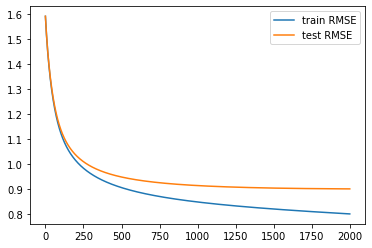

In [30]:
def predict_matrix_marks(users_matrix, movies_matrix, x1, x2):
  return (users_matrix[x1] * movies_matrix[x2]).sum(axis=1)

def matrix_factorization(
    ratings,
    test_ratings,
    rank,
    opti,
    steps=10,
    users_matrix=None,
    movies_matrix=None,
    early_stopping=True,
    l2=1,
  ):
  (x1, x2), Y = ratings
  (test_x1, test_x2), test_y = test_ratings

  if users_matrix is None:
    users_matrix = torch.rand((nb_users, rank), requires_grad=True, device=device)
  if movies_matrix is None:
    movies_matrix = torch.rand((nb_movies, rank), requires_grad=True, device=device)
  vars = [users_matrix, movies_matrix]

  if opti == 'sgd':
    optimizer = torch.optim.SGD(vars, lr=2)
  elif opti == 'asgd':
    optimizer = torch.optim.ASGD(vars, lr=2)
  elif opti == 'adam':
    optimizer = torch.optim.Adam(vars, lr=0.01)
  else:
    assert False

  errors, test_errors = [], []
  for i_step in range(steps):
    optimizer.zero_grad()
    diff = Y - predict_matrix_marks(users_matrix, movies_matrix, x1, x2)
    test_diff = test_y - predict_matrix_marks(users_matrix, movies_matrix, test_x1, test_x2)

    loss = rmse_loss(diff)
    regul = (l2 * (movies_matrix**2).mean()
        + l2 * (users_matrix**2).mean()
    )
    test_loss = rmse_loss(test_diff)
    errors.append(loss.detach().cpu().numpy())
    test_errors.append(test_loss.detach().cpu().numpy())
    if (early_stopping and len(test_errors) > 3 and 
      test_errors[-1] > test_errors[-2] and test_errors[-1] > test_errors[-3]
    ):
      steps = i_step+1
      break

    loss = loss + regul
    loss.backward()
    optimizer.step()
  if steps:
    print(f'After {steps} steps with {opti}, final loss {loss}')
  
  return users_matrix, movies_matrix, errors, test_errors

# for k in [2, 5, 10, 15, 20, 35, 50, 75]:
for k in [10]: # Optimal value
  print(f"====== With k={k}")
  users_matrix, movies_matrix, errors_1, test_errors_1 = matrix_factorization(
    train_ratings, test_ratings, k, 'adam', 0, l2=1e-2,
  )
  users_matrix, movies_matrix, errors_2, test_errors_2 = matrix_factorization(
    train_ratings, test_ratings, k, 'sgd', 2000, users_matrix, movies_matrix, l2=1e-2
  )
  predicted_marks = predict_matrix_marks(users_matrix, movies_matrix, *test_ratings[0])
  print("test RMSE of", float(rmse_marks(predicted_marks)))

  plt.plot(errors_1 + errors_2, label='train RMSE')
  plt.plot(test_errors_1 + test_errors_2, label='test RMSE')
  plt.legend()
  plt.show()

## With batches

====== With k=10
After 115 steps with sgd, final loss 0.7371718883514404
test RMSE of 0.89998347


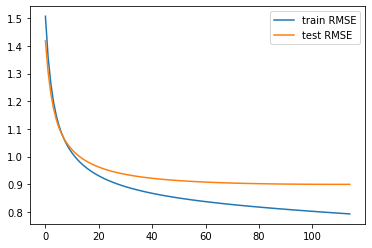

In [31]:
def predict_matrix_marks(users_matrix, movies_matrix, x1, x2):
  return (users_matrix[x1] * movies_matrix[x2]).sum(axis=1)

def matrix_factorization(
    ratings,
    test_ratings,
    rank,
    opti,
    steps=10,
    users_matrix=None,
    movies_matrix=None,
    early_stopping=0,
    l2=1,
    batch_size=2**12,
  ):
  (x1, x2), Y = ratings
  x1, x2, Y = torch.split(x1, batch_size), torch.split(x2, batch_size), torch.split(Y, batch_size)
  (test_x1, test_x2), test_y = test_ratings

  if users_matrix is None:
    users_matrix = torch.rand((nb_users, rank), requires_grad=True, device=device)
  if movies_matrix is None:
    movies_matrix = torch.rand((nb_movies, rank), requires_grad=True, device=device)
  vars = [users_matrix, movies_matrix]

  if opti == 'sgd':
    optimizer = torch.optim.SGD(vars, lr=2)
  elif opti == 'asgd':
    optimizer = torch.optim.ASGD(vars, lr=2)
  elif opti == 'adam':
    optimizer = torch.optim.Adam(vars, lr=0.01)
  else:
    assert False

  errors, test_errors = [], []
  for i_step in range(steps):
    step_losses = []
    # Train on each batch
    for x1_batch, x2_batch, y_batch in zip(x1, x2, Y):
      optimizer.zero_grad()
      diff = y_batch - predict_matrix_marks(users_matrix, movies_matrix, x1_batch, x2_batch)
      loss = rmse_loss(diff)
      
      regul = (
          ((users_matrix < 0) * users_matrix ** 2).mean()
          + ((movies_matrix < 0) * movies_matrix ** 2).mean()
          + l2 * (movies_matrix**2).mean()
          + l2 * (users_matrix**2).mean()
      )
      step_losses.append(loss.detach().cpu().numpy())
      loss = loss + regul
      loss.backward()
      optimizer.step()
    
    # Compute average train and test loss for the step
    errors.append(sum(step_losses)/len(step_losses))
    with torch.no_grad():
      test_diff = test_y - predict_matrix_marks(users_matrix, movies_matrix, test_x1, test_x2)
      test_loss = rmse_loss(test_diff)
      test_errors.append(test_loss.detach().cpu().numpy())
    
    # Stop if needed
    if (early_stopping and len(test_errors) > early_stopping and 
      all([test_errors[-1] > test_errors[-k-2] for k in range(early_stopping)])
    ):
      steps = i_step+1
      break

  if steps:
    print(f'After {steps} steps with {opti}, final loss {loss}')
  
  return users_matrix, movies_matrix, errors, test_errors

k = 10
print(f"====== With k={k}")
users_matrix, movies_matrix, errors_2, test_errors_2 = matrix_factorization(
  train_ratings, test_ratings, rank=k, opti='sgd', steps=200, l2=1e-2, early_stopping=3,
)
print("test RMSE of", test_errors_2[-1])

plt.plot(errors_1 + errors_2, label='train RMSE')
plt.plot(test_errors_1 + test_errors_2, label='test RMSE')
plt.legend()
plt.show()

# Transport optimal

## Create matrices

remove (0, 508)
remove (1, 46)
remove (2, 1996)
remove (3, 1971)
remove (4, 1153)
remove (5, 1795)
remove (6, 2392)
remove (7, 1492)
remove (8, 924)
remove (9, 197)
remove (10, 559)
remove (11, 1234)
remove (12, 810)
remove (13, 789)
remove (14, 418)
remove (15, 1558)
remove (16, 1703)
remove (17, 2794)
remove (18, 789)
remove (19, 513)
remove (20, 705)
remove (21, 2432)
remove (22, 2632)
remove (23, 810)
remove (24, 1443)
remove (25, 1516)
remove (26, 1332)
remove (27, 1686)
remove (28, 1561)
remove (29, 705)
remove (30, 1596)
remove (31, 1059)
remove (32, 701)
remove (33, 1733)
remove (34, 1486)
remove (35, 897)
remove (36, 783)
remove (37, 720)
remove (38, 1180)
remove (39, 954)
remove (40, 2252)
remove (41, 2370)
remove (42, 1673)
remove (43, 1742)
remove (44, 914)
remove (45, 819)
remove (46, 2632)
remove (47, 1525)
remove (48, 2784)
remove (49, 1479)
remove (50, 2458)
remove (51, 546)
remove (52, 2458)
remove (53, 1521)
remove (54, 919)
remove (55, 1075)
remove (56, 989)
remove (

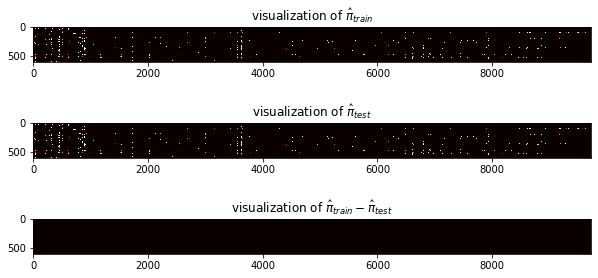

In [66]:
# issue with U_prime and V_prime because there are including both train and test datasets.
U_prime = users_matrix.detach().cpu().numpy()
V_prime = movies_matrix.detach().cpu().numpy()

X_train, Y_train = train_ratings
X_test, Y_test = test_ratings

m, n = U_prime.shape[0], V_prime.shape[0]

# transform U_prime and V_prime to a row matrix.
U_prime = U_prime.T
V_prime = V_prime.T

# create pi_hat: the matrix of predicted ratings.
pi_hat_train = np.zeros((m, n))
for (i, j), y in zip(X_train.T, Y_train):
  pi_hat_train[i][j] = y

pi_hat_test = pi_hat_train.copy()
for i in range(m):
  idx = np.random.choice(np.where(pi_hat_test[0,:] > 0)[0])
  print(f'remove ({i}, {idx})')
  pi_hat_test[i,idx] = 0

# add a small value to avoid division by 0
pi_hat_train += 10e-6
pi_hat_test += 10e-6


# normalize pi_hat.
pi_hat_train = pi_hat_train / np.sum(pi_hat_train)
pi_hat_test = pi_hat_test / np.sum(pi_hat_test)

_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5))
ax1.set_title('visualization of $\hat{\pi}_{train}$')
ax1.imshow(pi_hat_train, cmap='hot', interpolation='nearest')
ax2.set_title('visualization of $\hat{\pi}_{test}$')
ax2.imshow(pi_hat_test, cmap='hot', interpolation='nearest')
ax3.set_title('visualization of $\hat{\pi}_{train} - \hat{\pi}_{test}$')
ax3.imshow(np.abs(pi_hat_test - pi_hat_train), cmap='hot', interpolation='nearest')

In [67]:
print(f'U_prime shape: {U_prime.shape}')
print(f'V_prime shape: {V_prime.shape}')
print(f'pi_hat_train shape: {pi_hat_train.shape}')
print(f'pi_hat_test shape: {pi_hat_test.shape}')

U_prime shape: (10, 610)
V_prime shape: (10, 9724)
pi_hat_train shape: (610, 9724)
pi_hat_test shape: (610, 9724)


In [10]:
pi_hat_train

array([[1.41718330e-05, 3.54295825e-11, 3.54295825e-11, ...,
        3.54295825e-11, 3.54295825e-11, 3.54295825e-11],
       [3.54295825e-11, 3.54295825e-11, 3.54295825e-11, ...,
        3.54295825e-11, 3.54295825e-11, 3.54295825e-11],
       [3.54295825e-11, 3.54295825e-11, 3.54295825e-11, ...,
        3.54295825e-11, 3.54295825e-11, 3.54295825e-11],
       ...,
       [8.85739562e-06, 3.54295825e-11, 7.08591650e-06, ...,
        3.54295825e-11, 3.54295825e-11, 3.54295825e-11],
       [3.54295825e-11, 3.54295825e-11, 3.54295825e-11, ...,
        3.54295825e-11, 3.54295825e-11, 3.54295825e-11],
       [1.77147912e-05, 3.54295825e-11, 3.54295825e-11, ...,
        3.54295825e-11, 3.54295825e-11, 3.54295825e-11]])

## OT definition

In [11]:
# from https://github.com/ruilin-li/Learning-to-Match-via-Inverse-Optimal-Transport

import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import polynomial_kernel
from scipy.optimize import minimize


def rot(C, r, c, lam=1.0, max_iteration=100, tol=1e-6):
    '''
    This function computes the Sinkhorn distance between two discrete
    distributions r and c under cost matrix C

    Parameters:
        C: cost matrix, (m, n) np.ndarray
        r: row marginal, np.array
        c: column marginal, np.array
        lam: regularization constant
        L: number of iteartions in Sinkhorn-Knopp algorithm

    Return:
        pi: regularized optimal transport plan, (m, n) np.ndarray
        a: left scaling factor, np.array
        b: right scaling factor, np.array
        opt_cost: optimal sinkhorn distance, scalar
    '''
    m, n = C.shape

    K = np.exp(-lam * C)

    a, b = np.ones(m), np.ones(n)

    iteration, error = 0, np.inf

    while iteration < max_iteration and error > tol:
        next_b = c / np.dot(K.T, a)
        next_a = r / np.dot(K, next_b)
        error = np.linalg.norm(next_a - a) + np.linalg.norm(next_b - b)
        a, b = next_a, next_b

    pi = np.dot(np.diag(a),  K * b)

    loss = np.sum(pi * C) + 1 / lam * (np.sum(pi * np.log(pi)) - 1)

    return pi, a, b, loss


class train_parameters(object):
    def __init__(self, max_outer_iteration, max_inner_iteration, learning_rate):
        self.max_outer_iteration = max_outer_iteration
        self.max_inner_iteration = max_inner_iteration
        self.learning_rate = learning_rate


class model_parameters(object):
    def __init__(self, A0, gamma, const, degree, lam, lambda_mu, lambda_nu, delta):
        self.A0 = A0
        self.gamma = gamma
        self.const = const
        self.degree = degree
        self.lam = lam
        self.lambda_mu = lambda_mu
        self.lambda_nu = lambda_nu
        self.delta = delta


class Matcher():
    def __init__(self, pi_sample, U0, V0, r=5):
        self.pi_sample = pi_sample
        self.U0 = U0
        self.V0 = V0
        self.p, self.m = U0.shape
        self.q, self.n = V0.shape
        self.r = r

    def polynomial_kernel(self, model_param, train_param, method='gd'):
        # unpack model parameters
        A0 = model_param.A0
        gamma = model_param.gamma
        const = model_param.const
        degree = model_param.degree
        lam = model_param.lam
        lambda_mu = model_param.lambda_mu
        lambda_nu = model_param.lambda_nu
        delta = model_param.delta

        # gamma, const, degree = kernel_param[0], 1, kernel_param[1]
        # lam = lambda_nu = lambda_mu = 1

        # unpack training parameters
        max_iteration = train_param.max_outer_iteration
        learning_rate = train_param.learning_rate
        # max_iteration, learning_rate = train_param[0], train_param[1]

        A = A0
        r = self.pi_sample.sum(axis=1)
        c = self.pi_sample.sum(axis=0)

        history = []
        keys = ['iteration', 'loss', 'diff_pi_sample']

        if method == 'gd':
            for i in range(max_iteration):
                # update A
                C = np.power(
                    gamma * self.U0.T.dot(A).dot(self.V0) + const, degree)
                pi = rot(C, r, c)[0]
                factor = degree * gamma * \
                    np.power(gamma * self.U0.T.dot(A).dot(self.V0) +
                             const, degree - 1)
                M = (self.pi_sample - pi) * factor
                grad_A = self.U0.dot(M).dot(self.V0.T)
                A -= learning_rate * grad_A

                # compute loss
                loss = np.sum(self.pi_sample * C)  \
                    - np.sum(pi * C)      \
                    - np.sum(pi * np.log(pi))

                values = [i+1, loss, np.linalg.norm(pi - self.pi_sample)]
                history.append(dict(zip(keys, values)))

        if method == 'bfgs':
            iteration = [0]

            def func(A):
                A = A.reshape(self.p, self.q)
                C = np.power(gamma * self.U0.T.dot(A).dot(self.V0) + 1, degree)
                pi = rot(C, r, c)[0]
                loss = np.sum(self.pi_sample * C)  \
                    - np.sum(pi * C)      \
                    - np.sum(pi * np.log(pi))
                return loss

            def grad(A):
                A = A.reshape(self.p, self.q)
                C = np.power(gamma * self.U0.T.dot(A).dot(self.V0) + 1, degree)
                pi = rot(C, r, c)[0]
                factor = degree * gamma * \
                    np.power(gamma * self.U0.T.dot(A).dot(self.V0) +
                             1, degree - 1)
                M = (self.pi_sample - pi) * factor
                return self.U0.dot(M).dot(self.V0.T).ravel()

            def callback(A):
                A = A.reshape(self.p, self.q)
                C = np.power(gamma * self.U0.T.dot(A).dot(self.V0) + 1, degree)
                pi = rot(C, r, c)[0]
                values = [iteration[0]+1, func(A),
                          np.linalg.norm(pi - self.pi_sample)]
                history.append(dict(zip(keys, values)))
                iteration[0] += 1

            res = minimize(func, A.ravel(), method='BFGS', jac=grad,
                           callback=callback, options={'gtol': 1e-8, 'disp': True})
            A = res.x.reshape(self.p, self.q)

        C = np.power(gamma * self.U0.T.dot(A).dot(self.V0) + 1, degree)
        pi = rot(C, r, c)[0]
        return C, A, pi, history

    def riot(self, model_param, train_param):
        # unpack model parameters
        A0 = model_param.A0
        gamma = model_param.gamma
        const = model_param.const
        degree = model_param.degree
        lam = model_param.lam
        lambda_mu = model_param.lambda_mu
        lambda_nu = model_param.lambda_nu
        delta = model_param.delta

        # unpack training parameters
        max_outer_iteration = train_param.max_outer_iteration
        max_inner_iteration = train_param.max_inner_iteration
        learning_rate = train_param.learning_rate

        C1 = 5 * pairwise_distances(np.random.randn(self.m, 2))
        C2 = 5 * pairwise_distances(np.random.randn(self.n, 2))

        A = A0
        print(self.U0.shape, A.shape, self.V0.shape)
        C = np.power(gamma * self.U0.T.dot(A).dot(self.V0) + const, degree)

        r_sample, c_sample = self.pi_sample.sum(
            axis=1), self.pi_sample.sum(axis=0)
        v = np.log(rot(C1, r_sample, r_sample, lam=lambda_mu)[2]) / lambda_mu
        w = np.log(rot(C2, c_sample, c_sample, lam=lambda_nu)[2]) / lambda_nu
        v_dual = (np.log(r_sample) - np.log(np.sum(np.exp(lambda_mu *
                  (np.outer(np.ones(self.m), v) - C1)), axis=0))) / lambda_mu
        w_dual = (np.log(c_sample) - np.log(np.sum(np.exp(lambda_nu *
                  (np.outer(np.ones(self.n), w) - C2)), axis=0))) / lambda_nu

        pi, xi, eta = rot(C, r_sample, c_sample, lam)[:-1]

        def KL(pi1, pi2):
            p, q = pi1.ravel(), pi2.ravel()
            return np.sum(p * np.log(p / q))

        def rel_error(M, M0):
            return np.linalg.norm(M - M0) / np.linalg.norm(M0)

        def loss(pi, pi_sample, reg_para):
            ans = -np.sum(pi_sample * np.log(pi)) \
                + reg_para * (rot(C1, pi.sum(axis=1), pi_sample.sum(axis=1))
                              [-1] + rot(C2, pi.sum(axis=0), pi_sample.sum(axis=0))[-1])
            return ans

        losses = []
        KLs = []
        constraints = []
        best_loss = np.inf
        best_configuration = None

        for i in range(max_outer_iteration):
            Z = np.exp(- lam * C)
            M = delta * (np.outer(v, np.ones(self.n)) +
                         np.outer(np.ones(self.m), w)) * Z

            for j in range(max_inner_iteration):
                def p(theta):
                    xi1 = (r_sample / (M - theta * Z).dot(eta))
                    return xi1.dot(Z).dot(eta) - 1

                def q(theta):
                    return xi.dot(Z).dot(c_sample / (M - theta * Z).T.dot(xi)) - 1

                theta0 = np.min(M.dot(eta) / Z.dot(eta))
                theta1 = scipy.optimize.root(p, theta0-10).x[0]
                xi = r_sample / (M - theta1 * Z).dot(eta)

                theta0 = np.min(M.dot(eta) / Z.dot(eta))
                theta2 = scipy.optimize.root(q, theta0-10).x[0]
                eta = c_sample / (M - theta2 * Z).T.dot(xi)

            pi = np.dot(np.diag(xi), np.exp(-lam * C) * eta)

            grad_C = lam * (self.pi_sample + (theta1 - delta*(np.outer(v,
                            np.ones(self.n)) + np.outer(np.ones(self.m), w))) * pi)

            factor = grad_C * degree * gamma * \
                np.power(gamma * self.U0.T.dot(A).dot(self.V0) +
                         const, degree - 1)
            grad_A = self.U0.dot(factor).dot(self.V0.T)
            A -= learning_rate * grad_A
            C = np.power(gamma * self.U0.T.dot(A).dot(self.V0) + const, degree)

            v = np.log(rot(C1, pi.sum(axis=1), r_sample,
                       lambda_mu)[2]) / lambda_mu
            w = np.log(rot(C2, pi.sum(axis=0), c_sample,
                       lambda_nu)[2]) / lambda_nu
            v_dual = (np.log(pi.sum(axis=1)) - np.log(np.sum(np.exp(lambda_mu *
                      (np.outer(np.ones(self.m), v) - C1)), axis=0))) / lambda_mu
            w_dual = (np.log(pi.sum(axis=0)) - np.log(np.sum(np.exp(lambda_nu *
                      (np.outer(np.ones(self.n), w) - C2)), axis=0))) / lambda_nu

            losses.append(loss(pi, self.pi_sample, delta))
            KLs.append(KL(pi, self.pi_sample))

            if KLs[i] < best_loss:
                best_configuration = [C, A, pi]
                best_loss = KLs[i]

        self.A = A
        self.C = C
        return best_configuration


def computeRMSE(error):
    '''
    compute the root of mean squared error.
    '''
    rmse = np.sqrt(np.mean((error)**2))
    return rmse


def computeMAE(error):
    '''
    compute the mean absolute error.
    '''
    mae = np.mean(np.abs(error))
    return mae

In [13]:
from sklearn.model_selection import KFold

model = Matcher(pi_hat_train, U_prime, V_prime, r=5)
lam = 1
model_param = model_parameters(A0=np.eye(k, k),
                                        gamma=0.2,
                                        const=1,
                                        degree=2,
                                        lam=lam,
                                        lambda_mu=1,
                                        lambda_nu=1,
                                        delta=0.005)
train_param = train_parameters(max_outer_iteration=20,
                                        max_inner_iteration=10,
                                        learning_rate=0.01)
model.riot(model_param, train_param)
test_r, test_c = pi_hat_test.sum(axis=1), pi_hat_test.sum(axis=0)
pred_pi = rot(model.C, test_r, test_c, lam)[0]
error_OT = (pred_pi - pi_hat_test)
metric_RiOT = np.array([computeRMSE(error_OT), computeMAE(error_OT)])

(10, 610) (10, 10) (10, 9724)


In [19]:
(test_x1, test_x2), test_y = test_ratings
pred_mf = predict_matrix_marks(users_matrix, movies_matrix, test_x1, test_x2).detach().numpy()
pred_pi_mf = np.zeros((m, n)) + 1e-6
for i, j, y in zip(test_x1, test_x2, pred_mf):
    pred_pi_mf[i, j] = y

mf_mse = np.sqrt(np.mean((pred_pi_mf - pi_hat_test)**2))
ot_mse = np.sqrt(np.mean((pred_pi - pi_hat_test)**2))

print(' model   | RMSE')
print(' MF      | {:.8f}'.format(mf_mse))
print(' RiOT    | {:.8f}'.format(ot_mse))

 model   | RMSE
 MF      | 0.20728507
 RiOT    | 0.00000296


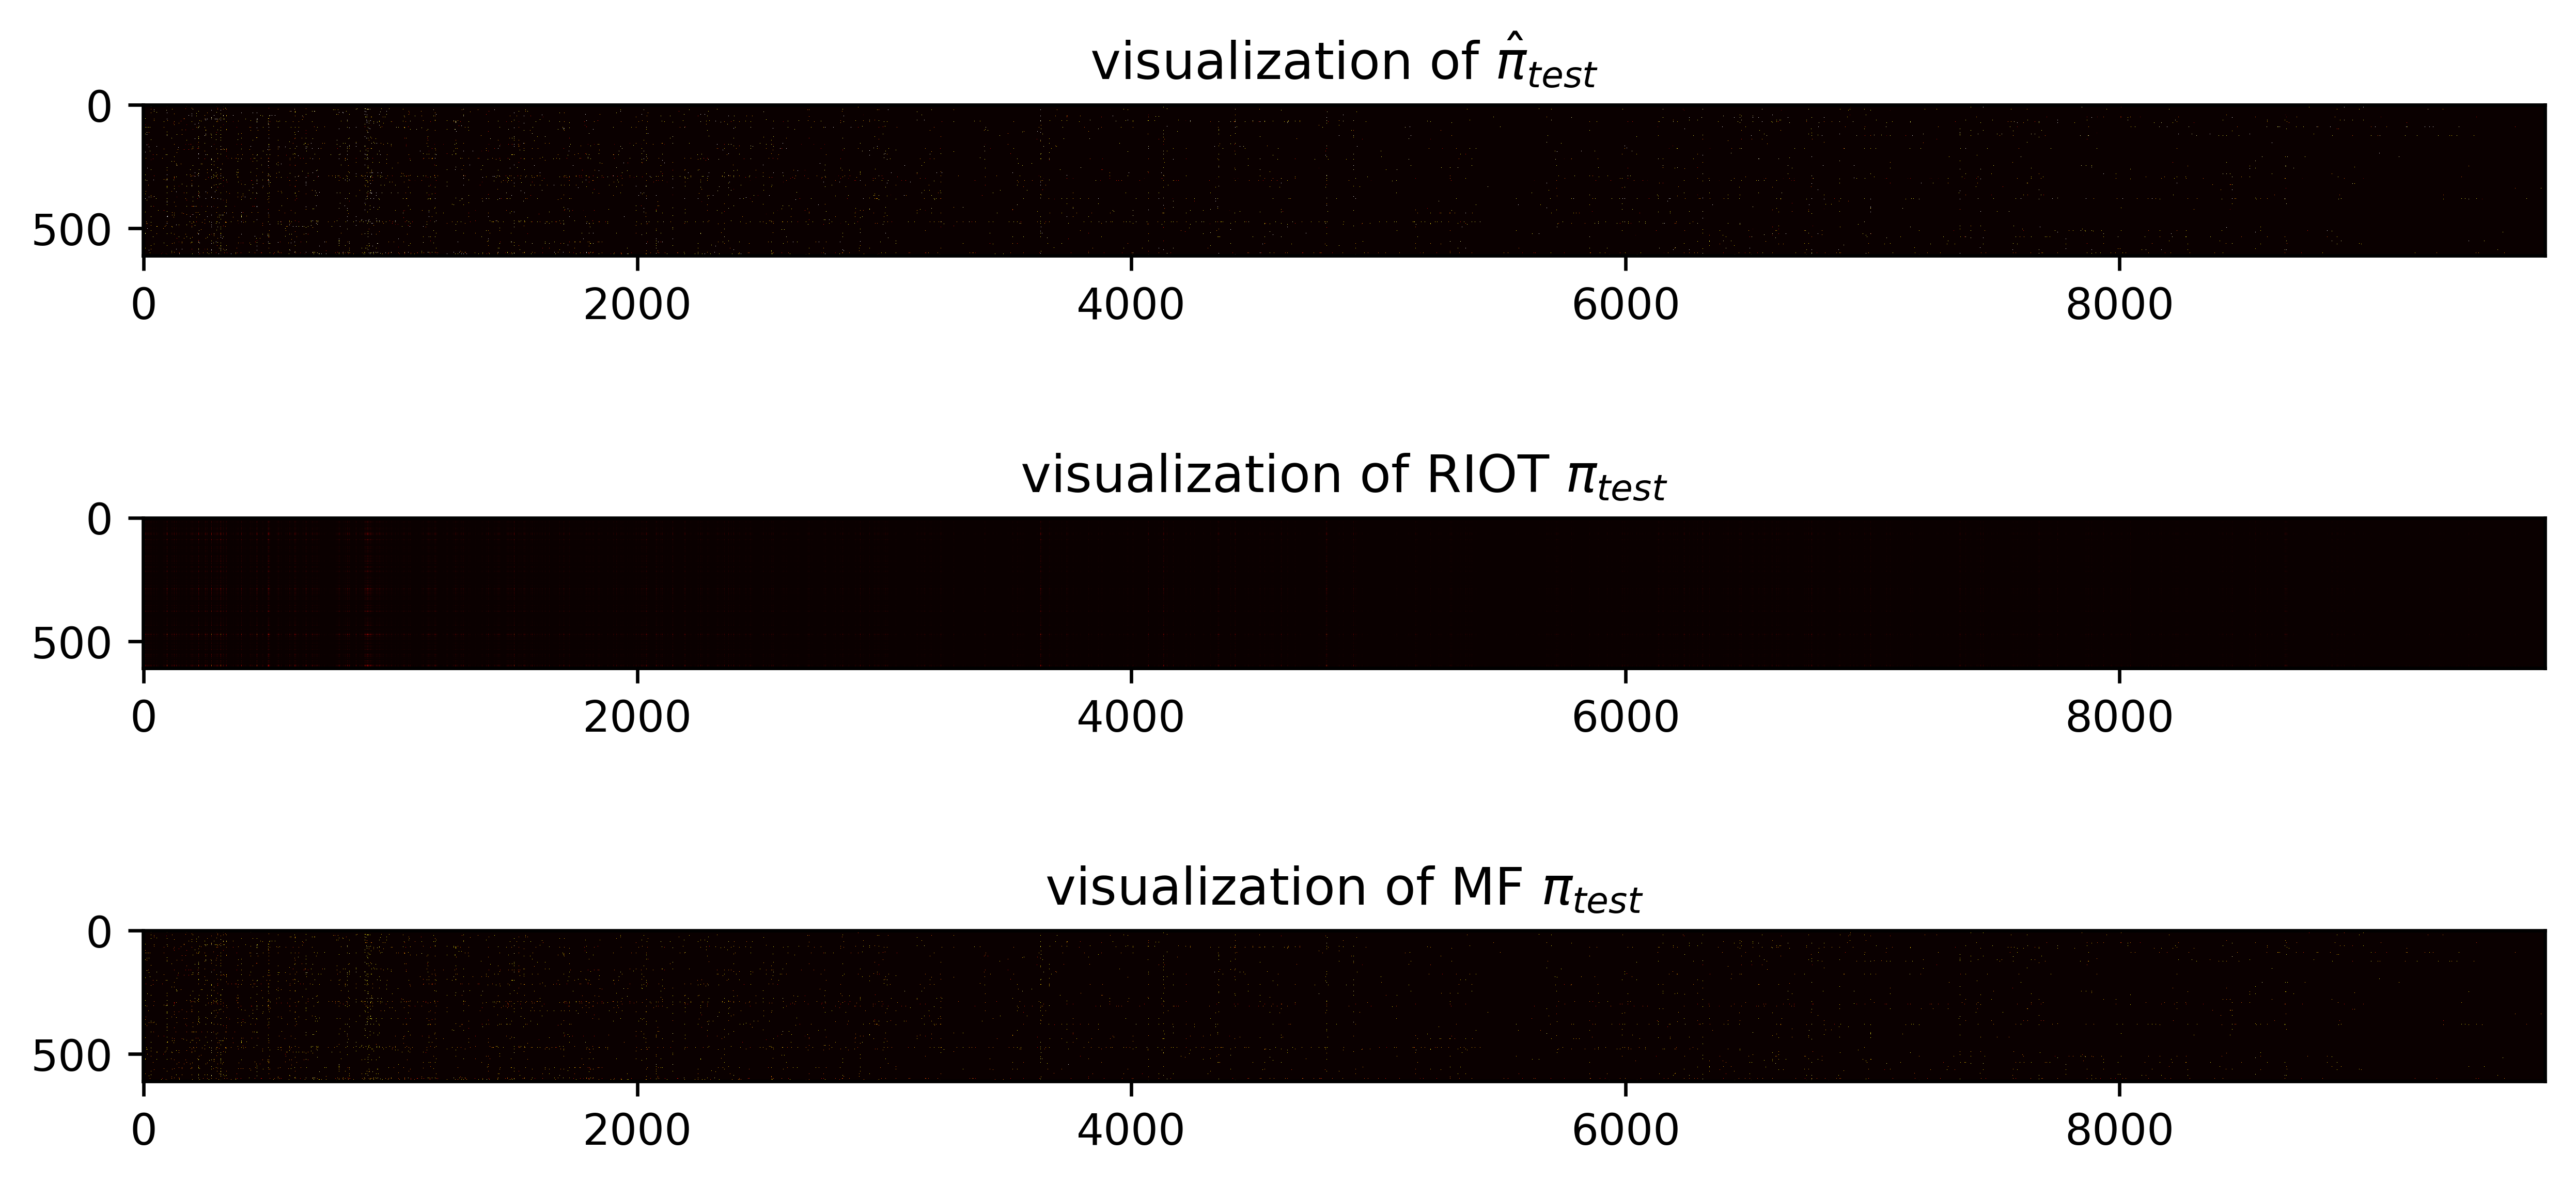

In [22]:
(test_x1, test_x2), test_y = test_ratings
pred_mf = predict_matrix_marks(users_matrix, movies_matrix, test_x1, test_x2).detach().numpy()
pred_pi_mf = np.zeros((m, n)) + 1e-6
for i, j, y in zip(test_x1, test_x2, pred_mf):
    pred_pi_mf[i, j] = y

_, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), dpi=600)
ax1.set_title('visualization of $\hat{\pi}_{test}$')
ax1.imshow(pi_hat_test, cmap='hot', interpolation='nearest')
ax2.set_title('visualization of RIOT ${\pi}_{test}$')
ax2.imshow(pred_pi, cmap='hot', interpolation='nearest')
ax3.set_title('visualization of MF ${\pi}_{test}$')
ax3.imshow(pred_pi_mf, cmap='hot', interpolation='nearest')

In [16]:
np.mean((pred_pi - pi_hat_test)**2)

8.769092800672582e-12

In [17]:
np.mean((pred_pi_mf - pi_hat_test)**2)

0.04296710062768319

# 0.04

In [71]:
df = pd.read_csv('ml-latest-small/ratings.csv')
df.userId -= 1
df.movieId -= 1
df

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,46,5.0,964983815
4,0,49,5.0,964982931
...,...,...,...,...
100831,609,166533,4.0,1493848402
100832,609,168247,5.0,1493850091
100833,609,168249,5.0,1494273047
100834,609,168251,5.0,1493846352


In [78]:
df = pd.read_csv('ml-latest-small/ratings.csv')

df.userId -= 1
df.movieId -= 1

user_ids = df.userId.unique()
movie_ids = df.movieId.unique()

n_users = len(user_ids)
n_movies = len(movie_ids)

assert (user_ids == np.arange(0, n_users)
        ).all(), "User ids are not contiguous"
assert (n_movies == np.arange(0, n_movies)
        ).all(), "Movie ids are not contiguous"

AssertionError: Movie ids are not contiguous

In [80]:
user_ids.data.contiguous

True

In [3]:
import pandas as pd

df = pd.read_csv('ml-latest-small/ratings.csv')

df.userId -= 1
df.movieId -= 1

user_ids = df.userId.unique()
movie_ids = df.movieId.unique()

assert user_ids.data.contiguous, "User ids are not contiguous"
assert movie_ids.data.contiguous, "Movie ids are not contiguous"

# "remove users that have only one rating"
df = df[df.rating > 1]

selected_ratings_by_user = df.groupby('userId').apply(lambda x: x.sample(1)).index.get_level_values(1)

train_ratings = df[~df.index.isin(selected_ratings_by_user)]
test_ratings = df[df.index.isin(selected_ratings_by_user)]


X_train = train_ratings[['userId', 'movieId']].to_numpy()
y_train = df['rating'].to_numpy()

X_test = test_ratings[['userId', 'movieId']].to_numpy()
y_test = df['rating'].to_numpy()

assert len(X_train) + len(X_test) == len(df), "Train and test sets are not disjoint"

In [174]:
X_train, y_train

(array([[     0,      0],
        [     0,      2],
        [     0,      5],
        ...,
        [   609, 168249],
        [   609, 168251],
        [   609, 170874]]),
 array([4., 4., 4., ..., 5., 5., 3.]))

In [166]:
df

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,46,5.0,964983815
4,0,49,5.0,964982931
...,...,...,...,...
100831,609,166533,4.0,1493848402
100832,609,168247,5.0,1493850091
100833,609,168249,5.0,1494273047
100834,609,168251,5.0,1493846352


In [160]:
df[~df.index.isin(test_ratings.index.get_level_values(1))]

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247
2,0,5,4.0,964982224
3,0,46,5.0,964983815
4,0,49,5.0,964982931
...,...,...,...,...
100831,609,166533,4.0,1493848402
100832,609,168247,5.0,1493850091
100833,609,168249,5.0,1494273047
100834,609,168251,5.0,1493846352


In [156]:
test_ratings

,,userId,movieId,rating,timestamp
userId,,,,,
0,95,0,1444,3.0,964984112
1,251,1,91528,3.5,1445714891
2,294,2,6834,5.0,1306463670
3,408,3,1733,3.0,964539357
4,543,4,409,3.0,847435292
...,...,...,...,...,...
605,98060,605,5186,4.0,1171810211
606,98602,606,2528,5.0,963078933
607,98862,607,1199,4.5,1117491293


In [142]:
test_ratings.rename_axis(['_', 'idx']).xs('idx', level='idx')

KeyError: 'idx'

In [109]:
df.iloc[34]

userId               0.0
movieId            592.0
rating               4.0
timestamp    964983793.0
Name: 34, dtype: float64

In [118]:
# panda select rows of df from test_ratings index
df.iloc[test_ratings.index]

ValueError: setting an array element with a sequence.

In [7]:
df.movieId, len(df.movieId.unique())

(0              0
 1              2
 2              5
 3             46
 4             49
            ...  
 100831    166533
 100832    168247
 100833    168249
 100834    168251
 100835    170874
 Name: movieId, Length: 96655, dtype: int64,
 9477)

In [9]:
df.movieId.replace(dict(zip(df.movieId.unique(), range(len(df.movieId.unique())))), inplace=True)

In [10]:
df.userId.replace(dict(zip(df.userId.unique(), range(len(df.userId.unique())))), inplace=True)

In [11]:
df

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
4,0,4,5.0,964982931
...,...,...,...,...
100831,609,3008,4.0,1493848402
100832,609,1937,5.0,1493850091
100833,609,3009,5.0,1494273047
100834,609,1342,5.0,1493846352


In [12]:
df.movieId, len(df.movieId.unique())

(0            0
 1            1
 2            2
 3            3
 4            4
           ... 
 100831    3008
 100832    1937
 100833    3009
 100834    1342
 100835    5973
 Name: movieId, Length: 96655, dtype: int64,
 9477)